# Shapley Values Talk

**Agenda**
1. Introdution & Motivation (see old anchor talk)
2. Shapley Values: Theory and Examples
3. Outlook to Kernel SHAP
4. Summary & Conclusion

In [31]:
# load modules

# data wrangling
from math import factorial
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from itertools import chain, combinations

# sklearn
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.metrics import classification_report, r2_score, explained_variance_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression

# alibi explainers
from alibi.explainers import AnchorTabular, KernelShap, TreeShap, shap_wrappers

# since I screwed up my kernel
import warnings
warnings.filterwarnings('ignore')

# plot adjustments
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 0. Motivation: Need for Explainability

- Makes AI models **more acceptable by the users**
- Helps by **debugging the model**, e.g. giving hints for FPs etc.
- Especially useful for very complex **black box models**
- Models can be **checked for “fairness”**
- maybe needed to follow **regulatories** in the future

*Comment: Focus on Local Explainability, i.e. we try to explain why the model predicted the outcome y for a single observation (feature vector) x*

## 1. Introduction
- introduced by Lloyd Shapley 1951 in the field of **cooperative game theory** as a solution concept
- naively phrased: *A team gets an overall payout. How important is each player to the overall cooperation and what payoff can he/she reasonable expect*
- nobel price in economics in 2012
- **in machine learning**:   

team $\rightarrow$ set of feature values  
payout (result of a game) $\rightarrow$ predicted value (one observation), i.e. either prediction probability (classification) or quantitative label (regression)   
individual player $\rightarrow$ feature value  
individual payoff $\rightarrow$ importance/share of the feature value to the target
- shapley values are basically used for **local explainability**, i.e. what is the specific feature value contribution to the prediction   
- however, they can also be used for global explainaibility
- before we dive into the math **let's create an example**

#### 1.1 Example: Boston Housepricing Regression

- famous boston dataset
- we reduce the feature space to basically **four features** for feasibility: **CRIM, DIS, INDUS, AGE**
- the goal is to pick out one observation and to try to explain the contribution to the price (payout) of the individual feature values (players)

*comment: a feature value is a certain realization of a feature, e.g. AGE=20 years*

**load data**

In [6]:
boston_data = load_boston()

In [7]:
# extract data
X_boston = boston_data["data"]
y_boston = boston_data["target"]
features_boston = boston_data["feature_names"]
meta_boston = boston_data["DESCR"]

In [8]:
print(meta_boston)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [9]:
# construct df
df_boston = pd.DataFrame(data=X_boston, columns=features_boston)
df_boston["PRICE"] = y_boston
df_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [10]:
features = ["CRIM", "DIS", "INDUS", "AGE"]
label_col = "PRICE"

**load data - done**

- we want to explain one specific observation
- let us first build a model and make predictions on the data

*comment: train and test will be the same here. We don't care here about getting a good model.*

In [11]:
# reduced data set
df_boston_reduced = df_boston[features + [label_col]].copy()
df_boston_reduced.head()

,CRIM,DIS,INDUS,AGE,PRICE
0,0.00632,4.0900,2.31,65.2,24.0
1,0.02731,4.9671,7.07,78.9,21.6
2,0.02729,4.9671,7.07,61.1,34.7
3,0.03237,6.0622,2.18,45.8,33.4
4,0.06905,6.0622,2.18,54.2,36.2


### 1.2: Linear Model for Explainability
**train a linear model**

$$f(x) =  \beta_0 + \sum_j \beta_j x_j$$

- we focus on just a few features here in order to get the whole idea
- the **average effect of a feature j** is actually $\beta_j \bar{x}_j$
- the contribution of a feature value $x_j$ to the whole predction f(x) is: $$\phi_j(x) = \beta_j x_j - \beta_j \bar{x}_j,$$  
where $\bar{x}_j$ is the average value across the data set for that feature j 
- let's quickly compute that contribution

In [12]:
# init model
model = LinearRegression()

# fit model
model.fit(df_boston_reduced[features], df_boston_reduced[label_col])

# predictions
y_pred = model.predict(df_boston_reduced[features])

# add to dataframe
df_boston_reduced["prediction"] = y_pred

# bad model, but we dont care here :D
r2_score(df_boston_reduced["PRICE"], df_boston_reduced["prediction"])

0.333602493617577

In [13]:
# betas
model.coef_

array([-0.25997588, -1.68506073, -0.65218584, -0.08692681])

In [14]:
# intercept (beta_0)
model.intercept_

43.091359175234885

In [15]:
df_boston_reduced.head()

,CRIM,DIS,INDUS,AGE,PRICE,prediction
0,0.00632,4.0900,2.31,65.2,24.0,29.023641
1,0.02731,4.9671,7.07,78.9,21.6,23.244915
2,0.02729,4.9671,7.07,61.1,34.7,24.792218
3,0.03237,6.0622,2.18,45.8,33.4,27.464756
4,0.06905,6.0622,2.18,54.2,36.2,26.725035


- next we compute the contribution of feature value j of the first observation/record (at index 0) to the target

In [17]:
# see formula above. these are the phi_js
feature_contributions = model.coef_ * df_boston_reduced[features].loc[0] - model.coef_ * df_boston_reduced[features].mean()
feature_contributions

CRIM     0.937786
DIS     -0.497021
INDUS    5.756700
AGE      0.293369
dtype: float64

- it seems like the **INDUS** feature value had the strongest contribution
- it adds ~5.7k to the mean (null) model

- The feature contributions must add up to the difference of prediction for x and the average.
- Summing over all feature value contributions leads to:

<img src="4.png">

In [20]:
# Efficiency (works in the case above)
feature_contributions.sum() + df_boston_reduced["PRICE"].mean()

29.023640679987675

**Can we do something similar for any type of model?**  
- It would be great to have this as a model-agnostic tool 
- Since we usually do not have similar weights in other model types, we need a different solution

Solution to this Problem:

### 2 Shapley Values
<img src="2.png">

**We will go step by step**

- definition (from wikipedia) looks rather complicated, but can be seen as a **model agnostic generalization** of the values we have computed for linear regression
- we compute the contribution of feature i of a certain target value observation v
- the **subtraction term** in the bracket is known as the **marginal contribution**. The first term can be seen as the prediction including the feature value of interest and the second term as the one where the effect has been left out (or integrated out like we do for averaging)
- the sum goes over **all possible sets of feature values** excluding the feature value i
- it is similar to the construction of a power set (see below)
- the combinatorical factor and the 1/n is for **weighting** (will be explained later)

### 2.1 Power Set for our Boston example

In [23]:
# power set
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [24]:
features

['CRIM', 'DIS', 'INDUS', 'AGE']

In [25]:
power_set = list(powerset(features))

In [26]:
power_set

[(),
 ('CRIM',),
 ('DIS',),
 ('INDUS',),
 ('AGE',),
 ('CRIM', 'DIS'),
 ('CRIM', 'INDUS'),
 ('CRIM', 'AGE'),
 ('DIS', 'INDUS'),
 ('DIS', 'AGE'),
 ('INDUS', 'AGE'),
 ('CRIM', 'DIS', 'INDUS'),
 ('CRIM', 'DIS', 'AGE'),
 ('CRIM', 'INDUS', 'AGE'),
 ('DIS', 'INDUS', 'AGE'),
 ('CRIM', 'DIS', 'INDUS', 'AGE')]

- This set contains $2^{n_{f}}$ elements (here 16)
- Shapley values are based on the idea that the **outcome of each possible combination** (or coalition) of players **should be considered** to determine the importance of a single player.
- the names above ("CRIM", etc.) in the power set represent actually the feature values for pur observation $x_0$ and not the feature (column) itself

In [27]:
# feature value set (known as feature vector)
x0_dict = df_boston_reduced[features].loc[0].to_dict()
x0_dict

{'CRIM': 0.00632, 'DIS': 4.09, 'INDUS': 2.31, 'AGE': 65.2}

- in order to leave out the effect of feature value i we need to **train a model without this feature**
- hence shap requires to **train a model M for each distinct coalition --> 16 models**
- the models are very similar (but differ in feature dimension)
- for the **empty feature set** of the power set (0 feature model) we just **predict the mean of all house prices** (null model)

**Let's train these models and get some results.**

*Comment: Even though our model is explainable by default, we stick to a linear regression model for simplicity* 

In [28]:
def get_model_results(x = df_boston_reduced.loc[0]):
    """Compute all model predictions for the feature vlaue sets of the power set"""
    
    # placeholder to collect
    model_results = {}
    
    # loop over the sets
    for features in power_set:
        
        # predict mean
        if len(features) < 1:
            model_results[features] = df_boston_reduced[label_col].mean()
            continue
        
        # fit the model
        model.fit(df_boston_reduced[list(features)], df_boston_reduced["prediction"])
        
        # store the model results for x0
        model_results[tuple(sorted(features))] = model.predict(np.array(x[list(features)].values).reshape(1,-1))[0]
        
    return model_results

In [30]:
model_results = get_model_results()
model_results

{(): 22.532806324110677,
 ('CRIM',): 24.030482171567453,
 ('DIS',): 22.85478556528352,
 ('INDUS',): 28.256884488076178,
 ('AGE',): 22.948468338051725,
 ('CRIM', 'DIS'): 24.009392888821814,
 ('CRIM', 'INDUS'): 28.03780028691965,
 ('AGE', 'CRIM'): 23.95982272199675,
 ('DIS', 'INDUS'): 29.572842931446186,
 ('AGE', 'DIS'): 22.91481539027567,
 ('AGE', 'INDUS'): 27.53006449820212,
 ('CRIM', 'DIS', 'INDUS'): 29.6623603858874,
 ('AGE', 'CRIM', 'DIS'): 23.959099008143657,
 ('AGE', 'CRIM', 'INDUS'): 27.542815159682153,
 ('AGE', 'DIS', 'INDUS'): 28.88659657340625,
 ('AGE', 'CRIM', 'DIS', 'INDUS'): 29.02364067998766}

- next we can **compute the marginal contributions** (subtraction terms):   
example for 'AGE': ('AGE', 'DIS', 'INDUS') - ('DIS', 'INDUS') 
- we compute the **contribution** of a player/feature value **to all possible coalitions**/team setups.
- in this way the formula above can be written as:

<img src="3.png">  

- hence, **the weighting factor** takes care of averaging the marginal contributions over the different coalations.

**let's compute the weighting factors (inverse of the number of coalitions) and the marginal contributions.**

In [32]:
def comb(n,k):
    """k out of n"""
    return factorial(n) / (factorial(k) * factorial(n-k)) 

In [33]:
def get_weight(subset_len, set_len):
    """computes the weighting factor"""
    return 1/(subset_len * comb(set_len, subset_len))

In [34]:
def get_marginals(feature = "CRIM", model_results = model_results, max_features=4):
    """computes weighted sum over all marginals"""
    
    marginals = {}
    weights = {}
    
    for key in model_results.keys():
        if key != () and feature in key:
            print("set with feature", key)
            print("set wo feature", set(key) - set([feature]))
            smaller_set = tuple(sorted(tuple(set(key) - set([feature]))))
            # print(smaller_set)
            marginals[key] = model_results[key] - model_results[smaller_set]
            print("marginal dist", marginals[key])
            print("")
    
    # weighting
    res = 0
    for key in marginals:
        weights[key] = get_weight(len(key), max_features)
        res += weights[key] * marginals[key]
    
    return marginals, weights, res

In [35]:
# result for CRIM
get_marginals()

set with feature ('CRIM',)
set wo feature set()
marginal dist 1.497675847456776

set with feature ('CRIM', 'DIS')
set wo feature {'DIS'}
marginal dist 1.1546073235382934

set with feature ('CRIM', 'INDUS')
set wo feature {'INDUS'}
marginal dist -0.2190842011565266

set with feature ('AGE', 'CRIM')
set wo feature {'AGE'}
marginal dist 1.0113543839450259

set with feature ('CRIM', 'DIS', 'INDUS')
set wo feature {'DIS', 'INDUS'}
marginal dist 0.08951745444121428

set with feature ('AGE', 'CRIM', 'DIS')
set wo feature {'DIS', 'AGE'}
marginal dist 1.0442836178679862

set with feature ('AGE', 'CRIM', 'INDUS')
set wo feature {'INDUS', 'AGE'}
marginal dist 0.012750661480033898

set with feature ('AGE', 'CRIM', 'DIS', 'INDUS')
set wo feature {'DIS', 'INDUS', 'AGE'}
marginal dist 0.13704410658140986



({('CRIM',): 1.497675847456776,
  ('CRIM', 'DIS'): 1.1546073235382934,
  ('CRIM', 'INDUS'): -0.2190842011565266,
  ('AGE', 'CRIM'): 1.0113543839450259,
  ('CRIM', 'DIS', 'INDUS'): 0.08951745444121428,
  ('AGE', 'CRIM', 'DIS'): 1.0442836178679862,
  ('AGE', 'CRIM', 'INDUS'): 0.012750661480033898,
  ('AGE', 'CRIM', 'DIS', 'INDUS'): 0.13704410658140986},
 {('CRIM',): 0.25,
  ('CRIM', 'DIS'): 0.08333333333333333,
  ('CRIM', 'INDUS'): 0.08333333333333333,
  ('AGE', 'CRIM'): 0.08333333333333333,
  ('CRIM', 'DIS', 'INDUS'): 0.08333333333333333,
  ('AGE', 'CRIM', 'DIS'): 0.08333333333333333,
  ('AGE', 'CRIM', 'INDUS'): 0.08333333333333333,
  ('AGE', 'CRIM', 'DIS', 'INDUS'): 0.25},
 0.6664657585192154)

In [36]:
# get all feature value contributions
results = {}
for feature in features:
    feature_contr = get_marginals(feature=feature)
    results[feature] = feature_contr[-1]

set with feature ('CRIM',)
set wo feature set()
marginal dist 1.497675847456776

set with feature ('CRIM', 'DIS')
set wo feature {'DIS'}
marginal dist 1.1546073235382934

set with feature ('CRIM', 'INDUS')
set wo feature {'INDUS'}
marginal dist -0.2190842011565266

set with feature ('AGE', 'CRIM')
set wo feature {'AGE'}
marginal dist 1.0113543839450259

set with feature ('CRIM', 'DIS', 'INDUS')
set wo feature {'DIS', 'INDUS'}
marginal dist 0.08951745444121428

set with feature ('AGE', 'CRIM', 'DIS')
set wo feature {'DIS', 'AGE'}
marginal dist 1.0442836178679862

set with feature ('AGE', 'CRIM', 'INDUS')
set wo feature {'INDUS', 'AGE'}
marginal dist 0.012750661480033898

set with feature ('AGE', 'CRIM', 'DIS', 'INDUS')
set wo feature {'DIS', 'INDUS', 'AGE'}
marginal dist 0.13704410658140986

set with feature ('DIS',)
set wo feature set()
marginal dist 0.32197924117284416

set with feature ('CRIM', 'DIS')
set wo feature {'CRIM'}
marginal dist -0.02108928274563837

set with feature ('DIS'

In [37]:
# final results
results

{'CRIM': 0.6664657585192154,
 'DIS': 0.8041665798001798,
 'INDUS': 5.240047688914611,
 'AGE': -0.2198456713570227}

- the inclusion of the specific feature value can be seen as the **differences to the null model** (here the mean)
- e.g. 'INDUS' increases the value by 5.2
- very similar to the results above; however note that we used the predictions here and not the model parameters.

**result above was**   

CRIM     0.937786   
DIS     -0.497021   
INDUS    5.756700   
AGE      0.293369    

*Comment: It differs because of the bad model :D*

In [38]:
# efficiency property still holds
df_boston_reduced["prediction"].mean() + sum(results.values())

29.02364067998766

In [39]:
# compare with efficiency result
df_boston_reduced.head()

,CRIM,DIS,INDUS,AGE,PRICE,prediction
0,0.00632,4.0900,2.31,65.2,24.0,29.023641
1,0.02731,4.9671,7.07,78.9,21.6,23.244915
2,0.02729,4.9671,7.07,61.1,34.7,24.792218
3,0.03237,6.0622,2.18,45.8,33.4,27.464756
4,0.06905,6.0622,2.18,54.2,36.2,26.725035


- this procedure is actually model agnostic
- for **classification** the **probability scores** and corresponding marginal contributions are being computed
- for a **large feature space** and **complex models** this requires a **lot of computational time**
- the shapely values fulfill additivity (you can add shapley values of model ensembles)

### 2.2 Shapely: Faster Estimators
- there are different strategies two approximate the shapley values, e.g. Monte Carlo methods or SHAP Kernel
- integrating out (averaging) the effect of a feature value contribution can be done by resampling from the data in a clever way

<img src="5.png">  

**Example in our four feature space case**  

$x_+ = [z1,z2,xj,z4]$  
$x_- = [z1,z2,zj,z4]$

or

$x_+ = [z1,x2,xj,z4]$  
$x_- = [z1,x2,zj,z4]$  


- using many of these x pairs leads to an approximation of the marginal distribution
- for more information have a look at: https://christophm.github.io/interpretable-ml-book/shapley.html

### Advantages of Shapley values
- contributions are **fairly distributed** among the features --> Efficiency property
- **contrastive explanations**: can be compared to null models or single observations
- **averaging all shapley values** for a feature gives an estimate of the **overall feature importance**

### Disadvantages
- **huge computational effort** which is often not feasiable --> approximate methods needed
- **sampling strategy dangerous** if some independed features are correlated --> **unrealistic samples** will be constructed
- solution: permutate correlated features together and compute a mutual set for them
- method returns a value, not a local model like LIME
- you need the data and the model to get shapley values   

Another faster approximation is the SHAP method:

### 3. SHAP Method for Shapley Value approximation

- SHAP (**shapley additive explanaions**) by Lundberg and Lee 2016
- **shapley values** are **used** in an additive manner **to create a local surrogate model** --> connects LIME and Shapley

$$g(z') = \phi_0+ \sum_j^M \phi_j z_j' ,$$ where
$z' \in {0,1}^M$, i.e. for instance $z' = (1,1,1,0)$ for our boston example (here the last feature is not "present").  

- if $z'$ is the unit vector $x'$ we have **local accuracy** due to the efficiency property, i.e $f(x) = g(x') = \phi_0+ \sum_j^M \phi_j x_j'$
- the **representation** as a linear model is a **trick to compute the shapley values**

*Naively we can say: The more 1's in z', the closer we are to x* 

**But how to get to the shapley values?**  

### 3.1 Kernel SHAP

**The steps** (explained later):

1. sample K coalitions $z_k'$
2. map $z_k'$ to original space x by using a mapping function $z=h_x(z')$ (mapping function defined below)
3. compute the model prediction f(z) = g(z') (efficiency property)
4. compute a weight for each coalition $z_k'$ with the SHAP Kernel (see below)
5. fit weighted linear model

$\rightarrow$ coeff are the shapley values (see eq. above)


Let's describe these steps in more detail:

**mapping function**

- the absence of a feature value is handled by random replacement from the feature distribution (see picture)

*Remember: we are interested in deriving the shapley values for x*

<img src="mapping.png">  

- now we have $z'$ and $g(z')$ pairs $\rightarrow$ we can fit the additive model above where the coefficients are the shapley values (hooray :D)
- the instances are weighted differently with the SHAP Kernel

**weighting**  

<img src="kernel.png">

- M is the number of features
- norm of z' is the number of 'present' features (number of 1's)
- this weighting **differs a lot from LIME**: Lime weights the instances by how close they are to the original instance (the more 0s the smaller the weights)
- SHAP weights the sampled instances according to the weight the coalition would get in the Shapley value estimation: small and large coalitions get the largest weight

**explanation regarding the weights**  

- we **learn most** about individual features if we study them **in isolation** (small coalitions) $\rightarrow$ **isolated main effect** in regression (effect by keeping everything else fixed)
- or **large coalitions** to get the **main effect + all interactions**
- **medium coalition** leads to less knowledge about the feature since we have **too many different coalitions of this kind**
- we can also use these weighting kernels for better sampling $\rightarrow$ sample more coalitions with a large weight

**this finally leads to the weighted regression model**

<img src="final.png">

### Summary
- averaging over all shapley values in your data set gives you the global feature importance:$I_j = 1/N \sum_i^N \vert \phi_j^i \vert$
- SHAP also has a fast implementation with tree based models
- due to the better efficiency (compared to the strategy above) it allows to get all needed values for global interpretation as well
- again: problems with dependent features (correlations) due to the sampling strategy
- in this way it is possible to create misleading interpretations which is maybe not a problem for a Data Scientist, but for a different consumer

### Excursion: the SHAP package

In [41]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [47]:
explainer = shap.LinearExplainer(model, df_boston_reduced[features], nsamples=100)

In [48]:
shap_values = explainer.shap_values(df_boston_reduced[features])

In [49]:
shap_values

array([[ 0.90648029, -0.48508349,  5.35646751,  0.18402405],
       [ 0.9010234 , -1.96305026,  2.25206292, -1.0068732 ],
       [ 0.9010286 , -1.96305026,  2.25206292,  0.54042395],
       ...,
       [ 0.8923272 ,  2.75444577, -0.91756026, -2.05868755],
       [ 0.87963258,  2.38137332, -0.91756026, -1.91091198],
       [ 0.89579788,  2.18573777, -0.91756026, -1.17203413]])

**differ due to correlations?**  

{'CRIM': 0.6664657585192154,
 'DIS': 0.8041665798001798,
 'INDUS': 5.240047688914611,
 'AGE': -0.2198456713570227}

In [50]:
# check correlations
df_boston_reduced[features].corr()

,CRIM,DIS,INDUS,AGE
CRIM,1.000000,-0.379670,0.406583,0.352734
DIS,-0.379670,1.000000,-0.708027,-0.747881
INDUS,0.406583,-0.708027,1.000000,0.644779
AGE,0.352734,-0.747881,0.644779,1.000000


we actually see correlated features here

In [57]:
features

['CRIM', 'DIS', 'INDUS', 'AGE']

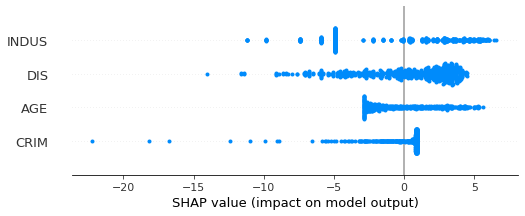

In [58]:
# all shapley values of the data set
shap.summary_plot(shap_values, feature_names=features)

In [66]:
 # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], df_boston_reduced[features].iloc[0,:])

In [65]:
# cluster features by shapley values
shap.force_plot(explainer.expected_value, shap_values, df_boston_reduced[features])

### References
- https://christophm.github.io/interpretable-ml-book/shap.html
- https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30
- https://docs.seldon.io/projects/alibi/en/stable/methods/KernelSHAP.html
- https://github.com/slundberg/shap